In [260]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter
from scipy.optimize import nnls
from sklearn.metrics import r2_score

In [2]:
# List of labels to easily extract absorption values from dataframe
mu_labels = []
for nums in range(101):
    if nums == 0:
        pass
    else:
        mu_labels.append("Mu" + str(nums))

In [3]:
mu_cn = pd.read_csv('../examples/mu_cn100.csv')
mu = mu_cn.drop(['CN', 'Num Te', 'Num Cu'], axis=1)
systems = pd.read_csv('../examples/sys100.csv')
weights = pd.read_csv('../examples/weights100.csv')
system_true = systems.iloc[99].dropna()
mu_true = mu.iloc[99].dropna()
weights_true = weights.iloc[99].dropna()
df = pd.read_excel('../examples/XANES_ML_Data.xlsx')
ref_data = df[df['System'].isin(system_true)]

In [453]:
# Sample out how many spectra to average
sample = df.sample(n=5)[mu_labels]
sample.head()

,Mu1,Mu2,Mu3,Mu4,Mu5,Mu6,Mu7,Mu8,Mu9,Mu10,...,Mu91,Mu92,Mu93,Mu94,Mu95,Mu96,Mu97,Mu98,Mu99,Mu100
147,0.029633,0.032090,0.034428,0.036754,0.039176,0.041800,0.044734,0.048086,0.051961,0.056471,...,0.982267,0.985562,0.989330,0.993610,0.998437,1.003848,1.009880,1.016569,1.023953,1.032066
131,0.029724,0.032139,0.034447,0.036753,0.039162,0.041778,0.044707,0.048053,0.051922,0.056420,...,0.980999,0.984597,0.988715,0.993368,0.998569,1.004335,1.010679,1.017617,1.025164,1.033334
4,0.031651,0.034223,0.036705,0.039216,0.041875,0.044800,0.048111,0.051924,0.056360,0.061550,...,0.996090,1.000765,1.005682,1.010798,1.016072,1.021460,1.026919,1.032406,1.037879,1.043295
96,0.031130,0.033811,0.036358,0.038897,0.041553,0.044450,0.047715,0.051472,0.055846,0.060971,...,0.996656,1.000663,1.004991,1.009591,1.014414,1.019414,1.024541,1.029748,1.034985,1.040206
89,0.031183,0.033828,0.036349,0.038872,0.041518,0.044412,0.047676,0.051434,0.055810,0.060935,...,0.994643,0.999053,1.003829,1.008898,1.014187,1.019624,1.025135,1.030648,1.036090,1.041388


In [454]:
# Systems selected from previous sample
df.iloc[sample.index]['System']

147     Cu2.83Te2-orthor-53355-R2/Cu1_2_95
131    Cu2.83Te2-orthor-53355-R1/Cu1_2_393
4              Cu1.5Te-629332-R1/Cu1_2_101
96               Cu2.8Te2-24173-R2/Cu1_243
89             Cu2.8Te2-24173-R2/Cu1_2_386
Name: System, dtype: object

In [455]:
# Can be used to randomly assign weights for each coefficient

# ws = np.random.dirichlet(np.ones(4), 1)

# coeff_a = ws[0][0]
# coeff_b = ws[0][1]
# coeff_c = ws[0][2]
# coeff_d = ws[0][3]
# coeff_e = ws[0][4]
# ws

array([[0.33269262, 0.06062795, 0.32706524, 0.27961419]])

Manually assigns weights for each coefficient below

In [456]:
# coeff_a = 0.125
# coeff_b = 0.225
# coeff_c = 0.1875
# coeff_d = 0.275
# coeff_e = 0.10
# coeff_f = 0.05
# coeff_g = 0.025
# coeff_h = 0.0125

In [457]:
coeff_a = 0.30
coeff_b = 0.15
coeff_c = 0.25
coeff_d = 0.20
coeff_e = 0.10
# coeff_f = 0.05

Expand reference spectra from 100 data points to n=1000. Also, calculate average spectrum depending on how many systems are being used, m. 

In [458]:
n = 1000
m = 4

xs = np.linspace(8970, 9050, n)
energies = np.linspace(8970, 9050, 100)

s1 = UnivariateSpline(energies, sample.iloc[0,:], s=0)
y1 = s1(xs)
s2 = UnivariateSpline(energies, sample.iloc[1,:], s=0)
y2 = s2(xs)
s3 = UnivariateSpline(energies, sample.iloc[2,:], s=0)
y3 = s3(xs)
s4 = UnivariateSpline(energies, sample.iloc[3,:], s=0)
y4 = s4(xs)
s5 = UnivariateSpline(energies, sample.iloc[4,:], s=0)
y5 = s5(xs)
# s6 = UnivariateSpline(energies, sample.iloc[5,:], s=0)
# y6 = s6(xs)
# s7 = UnivariateSpline(energies, sample.iloc[6,:], s=0)
# y7 = s7(xs)
# s8 = UnivariateSpline(energies, sample.iloc[7,:], s=0)
# y8 = s8(xs)

# y_ = y1*coeff_a + y2*coeff_b + y3*coeff_c + y4*coeff_d + y5*coeff_e + y6*coeff_f + y7*coeff_g + y8*coeff_h
# y_ = y1*coeff_a + y2*coeff_b + y3*coeff_c + y4*coeff_d + y5*coeff_e + y6*coeff_f + y7*coeff_g
# y_ = y1*coeff_a + y2*coeff_b + y3*coeff_c + y4*coeff_d + y5*coeff_e + y6*coeff_f
y_ = y1*coeff_a + y2*coeff_b + y3*coeff_c + y4*coeff_d + y5*coeff_e
# y_ = y1*coeff_a + y2*coeff_b + y3*coeff_c + y4*coeff_d

Plot of reference spectra.

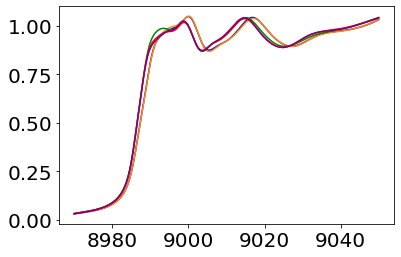

In [459]:
plt.plot(xs, y1, c='blue')
plt.plot(xs, y2, c='darkorange')
plt.plot(xs, y3, c='green')
plt.plot(xs, y4, c='red')
plt.plot(xs, y5, c='purple')
# plt.plot(xs, y6, c='pink')
# plt.plot(xs, y7, c='cyan')
# plt.plot(xs, y8, c='lime')
plt.show()

Add noise to the averaged spectrum, and attempt to smooth it out to simulate experimental data

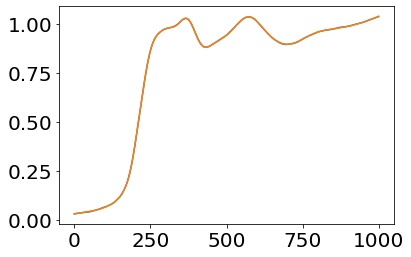

In [460]:
# noise = np.random.normal(0,0.01,1000) # Smoothed well with a 51, 2 savgol filter
noise = np.random.normal(0,0.005,1000) # Smoothed well with a 51, 2 savgol filter
# noise = np.random.normal(0,0.015,1000)
y_noise = y_ + noise
y_smooth = savgol_filter(y_noise, window_length=51, polyorder=2)
# y_smooth = savgol_filter(y_smooth, window_length=51, polyorder=2)
# y_ = y_smooth
# plt.plot(y_noise)
plt.plot(y_smooth)
plt.plot(y_)

In [462]:
# Measure of accuracy between the true averaged spectrum and the smoothed version.
print(r2_score(y_, y_smooth))

0.9999933124421864


Set up training data arrays.

In [448]:
X = np.zeros([n, m])
X[:,0] = y1
X[:,1] = y2
X[:,2] = y3
X[:,3] = y4
X[:,4] = y5
# X[:,5] = y6
# X[:,6] = y7
# X[:,7] = y8
# y = y_
y = y_smooth

Attempted to grid optimize the hyperparameters for a bayesian ridge regression model.. but didn't have an impact on the resulting coefficients

In [399]:
alpha_1 = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
alpha_2 = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
lambda_1 = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
lambda_2 = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
for i in alpha_1:
    for j in alpha_2:
        for k in lambda_1:
            for h in lambda_2:
                bayreg = BayesianRidge(alpha_1=i, alpha_2=j, lambda_1=k, lambda_2=h)
                bayreg.fit(X, y)
                Pred_train = bayreg.predict(X)
                print(bayreg.coef_)
# print(coeff_a, coeff_b, coeff_c, coeff_d, coeff_e)

[0.2774771  0.20755505 0.24997977 0.14527093 0.11893935]
[0.27747331 0.20755612 0.24997978 0.14526942 0.11894358]
[0.27747293 0.20755623 0.24997978 0.14526927 0.118944  ]
[0.27747289 0.20755624 0.24997978 0.14526926 0.11894405]
[0.27747289 0.20755624 0.24997978 0.14526925 0.11894405]
[0.27747289 0.20755624 0.24997978 0.14526925 0.11894405]
[0.27747727 0.207555   0.24997977 0.145271   0.11893917]
[0.27747348 0.20755607 0.24997978 0.14526949 0.11894339]
[0.2774731  0.20755618 0.24997978 0.14526934 0.11894382]
[0.27747306 0.20755619 0.24997978 0.14526932 0.11894386]
[0.27747306 0.20755619 0.24997978 0.14526932 0.11894386]
[0.27747306 0.20755619 0.24997978 0.14526932 0.11894386]
[0.27747729 0.207555   0.24997977 0.145271   0.11893915]
[0.2774735  0.20755607 0.24997978 0.1452695  0.11894337]
[0.27747311 0.20755617 0.24997978 0.14526934 0.1189438 ]
[0.27747308 0.20755618 0.24997978 0.14526933 0.11894384]
[0.27747307 0.20755619 0.24997978 0.14526933 0.11894384]
[0.27747307 0.20755619 0.249979

[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776587 0.20747343 0.24997874 0.14538614 0.11861747]
[0.27776443 0.20747384 0.24997875 0.14538556 0.11861907]
[0.27776429 0.20747388 0.24997875 0.14538551 0.11861924]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.2774771  0.20755505 0.24997977 0.14527093 0.11893935]
[0.27747331 0.20755612 0.24997978 0.14526942 0.11894358]
[0.27747293 0.20755623 0.24997978 0.14526927 0.118944  ]
[0.27747289 0.20755624 0.24997978 0.14526926 0.11894405]
[0.27747289 0.20755624 0.24997978 0.14526925 0.11894405]
[0.27747289 0.20755624 0.24997978 0.14526925 0.11894405]
[0.27747727 0.207555   0.24997977 0.145271   0.11893917]
[0.27747348 0.20755607 0.24997978 0.14526949 0.11894339]
[0.2774731  0.20755618 0.249979

[0.2777658  0.20747345 0.24997874 0.14538611 0.11861755]
[0.27776436 0.20747386 0.24997875 0.14538554 0.11861915]
[0.27776422 0.2074739  0.24997875 0.14538548 0.11861931]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.27776587 0.20747343 0.24997874 0.14538614 0.11861748]
[0.27776443 0.20747384 0.24997875 0.14538556 0.11861908]
[0.27776428 0.20747388 0.24997875 0.1453855  0.11861924]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861926]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861926]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861926]
[0.27776587 0.20747343 0.24997874 0.14538614 0.11861747]
[0.27776443 0.20747384 0.24997875 0.14538556 0.11861907]
[0.27776429 0.20747388 0.24997875 0.14538551 0.11861924]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.24997875 0.1453855  0.11861925]
[0.27776427 0.20747388 0.249978

[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861926]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.2777658  0.20747345 0.24997874 0.14538611 0.11861755]
[0.27776436 0.20747386 0.24997875 0.14538554 0.11861915]
[0.27776422 0.2074739  0.24997875 0.14538548 0.11861931]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.27776587 0.20747343 0.24997874 0.14538614 0.11861748]
[0.27776443 0.20747384 0.249978

[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861926]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.2777658  0.20747345 0.24997874 0.14538611 0.11861755]
[0.27776436 0.20747386 0.24997875 0.14538554 0.11861915]
[0.27776422 0.2074739  0.24997875 0.14538548 0.11861931]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.24997875 0.14538547 0.11861933]
[0.2777642  0.2074739  0.249978

[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.249978

[0.27776578 0.20747346 0.24997874 0.1453861  0.11861758]
[0.27776434 0.20747386 0.24997875 0.14538553 0.11861918]
[0.27776419 0.20747391 0.24997875 0.14538547 0.11861934]
[0.27776418 0.20747391 0.24997875 0.14538546 0.11861936]
[0.27776418 0.20747391 0.24997875 0.14538546 0.11861936]
[0.27776418 0.20747391 0.24997875 0.14538546 0.11861936]
[0.27776584 0.20747344 0.24997874 0.14538613 0.11861751]
[0.2777644  0.20747385 0.24997875 0.14538555 0.11861911]
[0.27776426 0.20747389 0.24997875 0.14538549 0.11861927]
[0.27776424 0.20747389 0.24997875 0.14538549 0.11861929]
[0.27776424 0.20747389 0.24997875 0.14538549 0.11861929]
[0.27776424 0.20747389 0.24997875 0.14538549 0.11861929]
[0.27776585 0.20747344 0.24997874 0.14538613 0.1186175 ]
[0.27776441 0.20747384 0.24997875 0.14538555 0.1186191 ]
[0.27776426 0.20747389 0.24997875 0.1453855  0.11861927]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.24997875 0.14538549 0.11861928]
[0.27776425 0.20747389 0.249978

In [449]:
random.seed(519)

sequence = [i for i in range(n)]
selection = [0]*n
for i in range(n):
    selection[i] = random.choice(sequence)

iter_ = n

coeffs = [[0.0 for a in range(m)] for b in range(iter_)]
rmse_prop = [0.0]*(iter_)

In [450]:
for k in range(0, iter_):
    n_tr = 1+k

    X_train_fl = [[0.0 for a in range(m)] for b in range(n_tr)]
    for i in range(0, n_tr):
        for j in range(0, m):
            X_train_fl[i][j] = copy.deepcopy(np.float(X[selection[i]][j]))

    Prop_train_fl = np.zeros(n_tr)
    for i in range(0, n_tr):
        Prop_train_fl[i] = copy.deepcopy(float(y[selection[i]]))

#     lassoreg = Lasso(alpha=1e-6, max_iter=1e8, positive=True)
#     lassoreg.fit(X_train_fl, Prop_train_fl)
#     bayreg = BayesianRidge()
#     bayreg.fit(X_train_fl, Prop_train_fl)
    linreg = LinearRegression()
    linreg.fit(X_train_fl, Prop_train_fl)
    Pred_train = linreg.predict(X_train_fl)
#     Pred_train = lassoreg.predict(X_train_fl)
#     Pred_train = bayreg.predict(X_train_fl)
#     Pred_train = lassoreg.predict(X_train_fl)

    for z in range(0,m):
        coeffs[k][z] = linreg.coef_[z]

    X_new = [[0.0 for a in range(m)] for b in range(n)]
    for s in range(0, n):
        for t in range(0, m):
            X_new[s][t] = copy.deepcopy(np.float(X[s][t]))

    Pred_test = linreg.predict(X_new)

    Pred_test_fl = np.zeros(n)
    for i in range(0, n):
        Pred_test_fl[i] = np.float(Pred_test[i])
#     plt.plot(xs, Pred_test_fl, color='blue', linewidth=4, label='Prediction')
#     plt.plot(xs, y_true, color='red', linewidth=4, label='True')
#     plt.title('Test Prediction: %s Data Points' % n_tr, fontsize = 24)
#     plt.xlabel('Energy (eV)', fontsize=24)
#     plt.ylabel('Absorption', fontsize=24)
#     plt.legend()
#     plt.show()
    mse_prop = mean_squared_error(y, Pred_test_fl)
    rmse_prop[k] = np.sqrt(mse_prop)
#     print(mlp.coefs_)

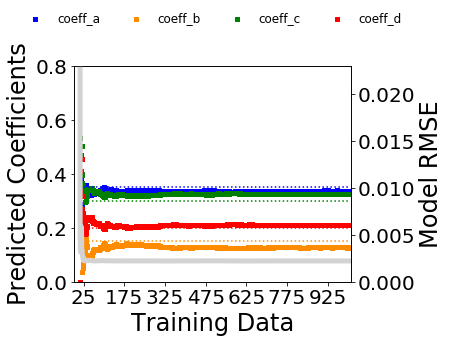

In [451]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)

l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l
yy4 = [0.0]*l
yy5 = [0.0]*l
yy6 = [0.0]*l
yy7 = [0.0]*l
yy8 = [0.0]*l

for i in range(0,l):
    xx[i] = i+10
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]
    yy4[i] = coeffs[i][3]
    yy5[i] = coeffs[i][4]
#     yy6[i] = coeffs[i][5]
#     yy7[i] = coeffs[i][6]
#     yy8[i] = coeffs[i][7]

ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')
ax1.scatter(xx, yy4, c='red', marker='s', s=10, alpha=1.0, label='coeff_d')
ax1.scatter(xx, yy5, c='purple', marker='s', s=10, alpha=1.0, label='coeff_e')
# ax1.scatter(xx, yy6, c='pink', marker='s', s=10, alpha=1.0, label='coeff_f')
# ax1.scatter(xx, yy7, c='cyan', marker='s', s=10, alpha=1.0, label='coeff_g')
# ax1.scatter(xx, yy8, c='lime', marker='s', s=10, alpha=1.0, label='coeff_h')


aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l
dd = [0.0]*l
ee = [0.0]*l
ff = [0.0]*l
gg = [0.0]*l
hh = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c
    dd[i] = coeff_d
    ee[i] = coeff_e
#     ff[i] = coeff_f
#     gg[i] = coeff_g
#     hh[i] = coeff_h

ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')
ax1.plot(xx, dd, c='red', ls=':')
ax1.plot(xx, ee, c='purple', ls=':')
# ax1.plot(xx, ff, c='pink', ls=':')
# ax1.plot(xx, gg, c='cyan', ls=':')
# ax1.plot(xx, hh, c='lime', ls=':')

ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
# ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])
ax1.set_ylim([0, 0.8])

ax2 = ax1.twinx()
ax2.plot(xx, rmse_prop, c='lightgrey', ls='-', lw=5)
ax2.set_ylabel('Model RMSE', color='k', fontname='Arial Narrow', size=24)
ax2.set_ylim([0.00,0.023])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.xlim([-10,n_tr+10])
# plt.xlim([0, n_tr])
plt.xticks([25, 175, 325, 475, 625, 775, 925])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})

plt.show()

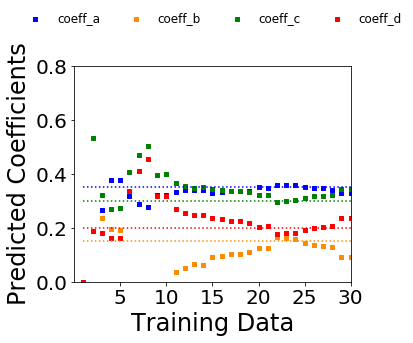

In [452]:
plt.rc('font', family='Arial narrow')

fig, ax1 = plt.subplots(1,1)
plt.subplots_adjust(left=0.16, bottom=0.17, right=0.80, top=0.92)

l = len(coeffs)
xx = [0.0]*l
yy1 = [0.0]*l
yy2 = [0.0]*l
yy3 = [0.0]*l
yy4 = [0.0]*l
yy5 = [0.0]*l
yy6 = [0.0]*l
yy7 = [0.0]*l
yy8 = [0.0]*l

for i in range(0,l):
    xx[i] = i+1
    yy1[i] = coeffs[i][0]
    yy2[i] = coeffs[i][1]
    yy3[i] = coeffs[i][2]
    yy4[i] = coeffs[i][3]
    yy5[i] = coeffs[i][4]
#     yy6[i] = coeffs[i][5]
#     yy7[i] = coeffs[i][6]
#     yy8[i] = coeffs[i][7]

ax1.scatter(xx, yy1, c='blue', marker='s', s=10, alpha=1.0, label='coeff_a')
ax1.scatter(xx, yy2, c='darkorange', marker='s', s=10, alpha=1.0, label='coeff_b')
ax1.scatter(xx, yy3, c='green', marker='s', s=10, alpha=1.0, label='coeff_c')
ax1.scatter(xx, yy4, c='red', marker='s', s=10, alpha=1.0, label='coeff_d')
ax1.scatter(xx, yy5, c='purple', marker='s', s=10, alpha=1.0, label='coeff_e')
# ax1.scatter(xx, yy6, c='pink', marker='s', s=10, alpha=1.0, label='coeff_f')
# ax1.scatter(xx, yy7, c='cyan', marker='s', s=10, alpha=1.0, label='coeff_g')
# ax1.scatter(xx, yy8, c='lime', marker='s', s=10, alpha=1.0, label='coeff_h')

aa = [0.0]*l
bb = [0.0]*l
cc = [0.0]*l
dd = [0.0]*l
ee = [0.0]*l
ff = [0.0]*l
gg = [0.0]*l
hh = [0.0]*l

for i in range(0,l):
    aa[i] = coeff_a
    bb[i] = coeff_b
    cc[i] = coeff_c
    dd[i] = coeff_d
    ee[i] = coeff_e
#     ff[i] = coeff_f
#     gg[i] = coeff_g
#     hh[i] = coeff_h

ax1.plot(xx, aa, c='blue', ls=':')
ax1.plot(xx, bb, c='darkorange', ls=':')
ax1.plot(xx, cc, c='green', ls=':')
ax1.plot(xx, dd, c='red', ls=':')
ax1.plot(xx, ee, c='purple', ls=':')
# ax1.plot(xx, ff, c='pink', ls=':')
# ax1.plot(xx, gg, c='cyan', ls=':')
# ax1.plot(xx, hh, c='lime', ls=':')

ax1.set_ylabel('Predicted Coefficients', color='k', fontname='Arial Narrow', size=24)
ax1.set_xlabel('Training Data', color='k', fontname='Arial Narrow', size=24)
# ax1.set_ylim([min(np.min(yy1), np.min(yy2), np.min(yy3))-0.05, max(np.max(yy1), np.max(yy2), np.max(yy3))+0.05 ])
ax1.set_ylim([0, 0.8])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
# plt.xlim([-10,n_tr+10])
plt.xticks([5, 10, 15, 20, 25, 30])

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, frameon=False, prop={'family':'Arial narrow','size':12})
plt.xlim([0,30])
plt.show()